# Importing Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score, recall_score, confusion_matrix, f1_score
from imblearn.over_sampling import RandomOverSampler
import warnings
from sklearn.exceptions import FitFailedWarning
warnings.simplefilter('ignore', FitFailedWarning)
from sklearn.decomposition import PCA

# Importing Dataset

In [3]:
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [ ]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


# No Missing Values

In [ ]:
df.isna().any().any()

False

# Encoding Categorical Values

In [4]:
#Columns with string values
categorical_column = ['Attrition', 'BusinessTravel', 'Department','Gender', 'JobRole', 'MaritalStatus', 'OverTime','EducationField']
encoder=LabelEncoder()
df[categorical_column]=df[categorical_column].apply(encoder.fit_transform)

# Seperating into X and y

In [5]:
y=df['Attrition']
X=df.drop(['EmployeeCount','Attrition','EmployeeNumber','Over18','StandardHours'],axis=1)

# Spliting into Train and Test Sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

## PCA

Two PCs explain [ 70.04405459  99.77480823  99.99910635  99.99966506  99.9997675
  99.99985408  99.99991695  99.99993538  99.99995189  99.99996012
  99.99996819  99.99997524  99.9999806   99.9999848   99.99998727
  99.99998943  99.99999106  99.99999262  99.99999415  99.99999549
  99.99999679  99.99999749  99.99999813  99.99999874  99.99999907
  99.99999934  99.99999959  99.9999998   99.99999993 100.        ] % of variance cumulatively


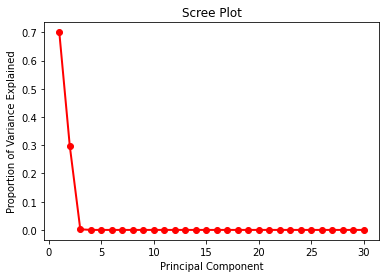

In [7]:
pca = PCA(random_state=0)
principalComponents = pca.fit_transform(X_train)
# print(pca.explained_variance_ratio_)
print('Two PCs explain', np.cumsum(pca.explained_variance_ratio_)*100, '% of variance cumulatively')
# scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

Two PCs explain [70.04405459 99.77480823] % of variance cumulatively


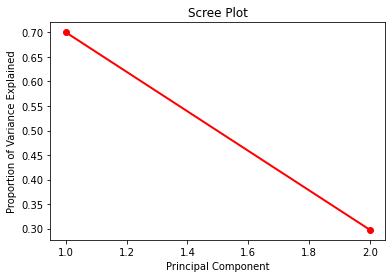

In [8]:
pca = PCA(n_components=2, random_state=0)
principalComponents = pca.fit_transform(X_train)
# print(pca.explained_variance_ratio_)
print('Two PCs explain', np.cumsum(pca.explained_variance_ratio_)*100, '% of variance cumulatively')
# scree plot
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [9]:
X_train = principalComponents
X_test = pca.transform(X_test)

# Applying Random Forest

In [10]:
def train_predict_evaluate(model,X_train,y_train,X_test):
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  print("Accuracy: ",accuracy_score(y_test,y_pred))
  print("Precision: ",precision_score(y_test,y_pred))
  print("Recall: ",recall_score(y_test,y_pred))
  print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest Classifier
# Setting random state for randomization
rf = RandomForestClassifier(random_state=42)


# Hyperparameter Tuning

Randomized Search Cross Validation

In [12]:
from sklearn.model_selection import RandomizedSearchCV

# Taking a huge range of values to get nearer to optimal parameters

# Parameters to check
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 150, num = 10)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

# Creating random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [13]:
# Using the random grid to search for best hyperparameters

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=2, 
                               random_state=42, n_jobs = -1)


In [14]:
# Training model and printing results
train_predict_evaluate (rf_random, X_train, y_train, X_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.4min finished


Accuracy:  0.81859410430839
Precision:  0.2
Recall:  0.012987012987012988
Confusion Matrix:
 [[360   4]
 [ 76   1]]


In [15]:
# Finding the best parameters
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 150,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 600}

Grid Search Cross Validation

In [16]:
from sklearn.model_selection import GridSearchCV

# After getting near to optimal values, using Random Search CV, 
# we now check for close values using Grid Search CV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [100, 105, 110, 115],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [2,3,4],
    'n_estimators': [250,300,350,400]
}

In [17]:
# Grid Search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Results on the Grid Search model
train_predict_evaluate (grid_search, X_train, y_train, X_test)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  3.5min finished


Accuracy:  0.8027210884353742
Precision:  0.2916666666666667
Recall:  0.09090909090909091
Confusion Matrix:
 [[347  17]
 [ 70   7]]


In [18]:
# Finding the best parameters
grid_search.best_params_

{'bootstrap': False,
 'max_depth': 100,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 300}

In [19]:
# Hyperparameter Tuning done
# Best parameters found above
# Using these parameters on our Random Forest model for most optimal results
best_rf = RandomForestClassifier(bootstrap=False, max_depth=100, 
                                 min_samples_leaf=1,min_samples_split=2, 
                                 n_estimators=250, random_state=42)
train_predict_evaluate (best_rf, X_train, y_train, X_test)

Accuracy:  0.7868480725623582
Precision:  0.3111111111111111
Recall:  0.18181818181818182
Confusion Matrix:
 [[333  31]
 [ 63  14]]


# K-Fold Cross Validation

In [20]:
def cross_validation(model,X,y):
  scores = cross_validate(model, X, y, cv=5,scoring=('accuracy','precision','recall','f1'))

  print("Accuracy: ", np.mean(scores['test_accuracy']))
  print("Precision: ", np.mean(scores['test_precision']))
  print("Recall: ", np.mean(scores['test_recall']))
  print("F1 Score: ", np.mean(scores['test_f1']))


Performing K-Fold Cross Validation on our model

In [21]:
# On model without Hyperparameter Tuning
cross_validation(rf, X, y)

Accuracy:  0.8571428571428571
Precision:  0.7703030303030303
Recall:  0.1646276595744681
F1 Score:  0.2691327643740822


In [22]:
# On model with Hyperparameter Tuning
cross_validation(best_rf, X, y)

Accuracy:  0.8571428571428571
Precision:  0.6867647058823529
Recall:  0.2153368794326241
F1 Score:  0.32384920634920633
